## Ex-03

### Task-01

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, load_digits
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import seaborn as sns

<div style="color: green; font-weight:bold"><ul>
<li>Sample solution defined the seperate method to create model layers, while we kept initialization of model layers inside the class. We believe that both strategies are equally fine. Other than this, the programming logic in both codes does not have a difference which will create a significant computation difference.</li>
</ul></div>

In [9]:
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.input1 = int(np.round(self.input_size/2))
        self.input2 = self.input_size-self.input1
        self.encoder = nn.Sequential(
            nn.Linear(self.input1, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 2 * self.input2)
            )

    def forward(self, x, rev=False):
        x1, x2 = x[...,:self.input1], x[..., self.input1:]
        param = self.encoder(x1)
        scale, translation = param[..., :self.input2], param[..., self.input2:]
        scale = torch.tanh(scale)
        log_jacob_det = torch.sum(scale, -1)

        if rev:
            scale = torch.exp(-scale)
            x2 = scale*(x2-translation)
            return torch.cat([x1,x2], -1)
        else:
            scale = torch.exp(scale)
            x2 = scale*x2 + translation
            return torch.concat([x1,x2], -1), log_jacob_det

<div style="color: green; font-weight:bold"><ul>
<li>The method, special_ortho_group, used by the sample solution seems to be more computationally safe and computationally efficient.</li>
<li>Sample solution class achieves better modularity.</li>
</ul></div>

In [10]:
def gram_schmidt(matrix):
    n, _ = matrix.shape
    orthogonal_matrix = torch.zeros_like(matrix)

    for i in range(n):
        vector = matrix[i]
        for j in range(i):
            proj = torch.dot(vector, orthogonal_matrix[j]) * orthogonal_matrix[j]
            vector = vector - proj
        orthogonal_matrix[i] = vector / torch.norm(vector)

    return orthogonal_matrix

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        self.coupling_blocks = nn.ModuleList()
        for _ in range(blocks):
            self.coupling_blocks.append(CouplingLayer(input_size, hidden_size))

        random_matrices = [torch.randn(input_size, input_size) for _ in range(blocks - 1)]
        self.orthogonal_matrices = [gram_schmidt(matrix) for matrix in random_matrices]

    def forward(self, x, rev=False):
        if rev:
            for i in range(self.blocks - 1, 0, -1):
                x = self.coupling_blocks[i](x, rev=True)
                x = torch.matmul(x, self.orthogonal_matrices[i - 1].T)
            x = self.coupling_blocks[0](x, rev=True)
            return x
        else:
            log_jacob_det = torch.zeros((x.shape[0]), device=x.device)
            for i in range(self.blocks - 1):
                x, x_log_jacob_det = self.coupling_blocks[i](x)
                log_jacob_det += x_log_jacob_det
                x = torch.matmul(x, self.orthogonal_matrices[i])
            x, x_log_jacob_det = self.coupling_blocks[-1](x)
            log_jacob_det += x_log_jacob_det
            return x, log_jacob_det

    def sample(self, num_samples):
        z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples,self.input_size)))
        return self.forward(z, rev=True)

<div style="color: green; font-weight:bold"><ul>
<li>We have used the data loader which we believe is always a better strategy.</li>
<li>A small difference in calculation of loss, where we believe that directly using torch.mean() is computationally more effective.</li>
</ul></div>

In [11]:
def train_inn(model, data_loader, optimizer, epochs):
    for _ in range(epochs):
        for x, _ in data_loader:
            optimizer.zero_grad()

            x = x.view(x.size(0), -1)
            z, log_det = model(x)
            loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - log_det)

            loss.backward()
            optimizer.step()

        # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


<div style="color: green; font-weight:bold"><ul>
<li>We have normalized the data, which is missed by the sample solution.</li>
</ul></div>

In [12]:
def generate_data(n_samples=1000, noise=0.1, random_state=1):
    data, _ = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    data = StandardScaler().fit_transform(data)

    data = torch.tensor(data, dtype=torch.float32)
    return data

In [13]:
def evaluate_model(model, test_data):
    model.eval()

    total_loss = 0
    with torch.no_grad():

        z, log_det = model(test_data)
        loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - log_det)

        total_loss+=loss.item()
    return total_loss/len(test_data)

<div style="color: green; font-weight:bold"><ul>
<li>Both programs use different strategies for evaluating and representing results of hyperparameters. Hence, we believe that they can not be compared</li>
</ul></div>

In [14]:
def plot_hyperparameter_combinations(data, n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list):

    hyperparam_comb = list(itertools.product(hidden_size_list, blocks_list, epochs_list))
    len_comb = len(hyperparam_comb)

    n_cols = 4
    n_rows = (len_comb + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    for i, (hidden_size, blocks, epochs) in enumerate(hyperparam_comb):
        ax = axes[i]


        model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = TensorDataset(data, torch.zeros(data.size(0)))
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        train_inn(model, data_loader, optimizer, epochs=epochs)

        samples = model.sample(n_samples).detach().numpy()

        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Original')
        ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated')
        ax.set_title(f'Epochs: {epochs}, Hidden_size: {hidden_size}, Blocks: {blocks}')
        ax.legend()

    for i in range(len(hyperparam_comb), len(axes)):
        fig.delaxes(axes[i])


    plt.tight_layout()
    plt.show()

In [15]:
def evaluate_hyperparameters(n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list):

    results = []

    train_data = generate_data(n_samples=n_samples, noise=0.1, random_state=1)
    test_data = generate_data(n_samples=n_samples, noise=0.1, random_state=1)

    train_dataset = TensorDataset(train_data, torch.zeros(train_data.size(0)))
    data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for hidden_size in hidden_size_list:
        for blocks in blocks_list:

            model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
            optimizer = optim.Adam(model.parameters(), lr=lr)

            for epochs in epochs_list:
                train_inn(model, data_loader, optimizer, epochs)
                test_loss = evaluate_model(model, test_data)


                results.append({
                    'hidden_size': hidden_size,
                    'blocks': blocks,
                    'epochs': epochs,
                    'test_loss': test_loss
                })
                print(f'hidden_size={hidden_size}, blocks={blocks}, epochs={epochs} -> test_loss: {test_loss:3f}')

    plot_hyperparameter_combinations(train_data, n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list)

    param_keys = ['hidden_size', 'blocks', 'epochs']
    fig, axes = plt.subplots(1, len(param_keys), figsize=(len(param_keys)*4,3))

    for i, key in enumerate(param_keys):
        param_vals = sorted(set([result[key] for result in results]))
        mean_losses = []
        for val in param_vals:
            losses = [result['test_loss'] for result in results if result[key]==val]
            mean_losses.append(np.mean(losses))

        axes[i].plot(param_vals, mean_losses, marker='o')
        axes[i].set_title(f'Reconstruction Error for {key}')
        axes[i].set_xlabel(key)
        axes[i].set_ylabel('Reconstruction error')
        axes[i].grid()

    plt.tight_layout()
    plt.show()



    return results

hidden_size=32, blocks=6, epochs=10 -> test_loss: 0.000442
hidden_size=32, blocks=6, epochs=100 -> test_loss: 0.000160
hidden_size=32, blocks=8, epochs=10 -> test_loss: 0.000451
hidden_size=32, blocks=8, epochs=100 -> test_loss: 0.000052
hidden_size=32, blocks=10, epochs=10 -> test_loss: 0.000529
hidden_size=32, blocks=10, epochs=100 -> test_loss: 0.000038
hidden_size=64, blocks=6, epochs=10 -> test_loss: 0.000349
hidden_size=64, blocks=6, epochs=100 -> test_loss: 0.000047
hidden_size=64, blocks=8, epochs=10 -> test_loss: 0.000374
hidden_size=64, blocks=8, epochs=100 -> test_loss: 0.000131
hidden_size=64, blocks=10, epochs=10 -> test_loss: 0.000486
hidden_size=64, blocks=10, epochs=100 -> test_loss: 0.000158
hidden_size=128, blocks=6, epochs=10 -> test_loss: 0.000490
hidden_size=128, blocks=6, epochs=100 -> test_loss: 0.000073
hidden_size=128, blocks=8, epochs=10 -> test_loss: 0.000468
hidden_size=128, blocks=8, epochs=100 -> test_loss: 0.000187
hidden_size=128, blocks=10, epochs=10 ->

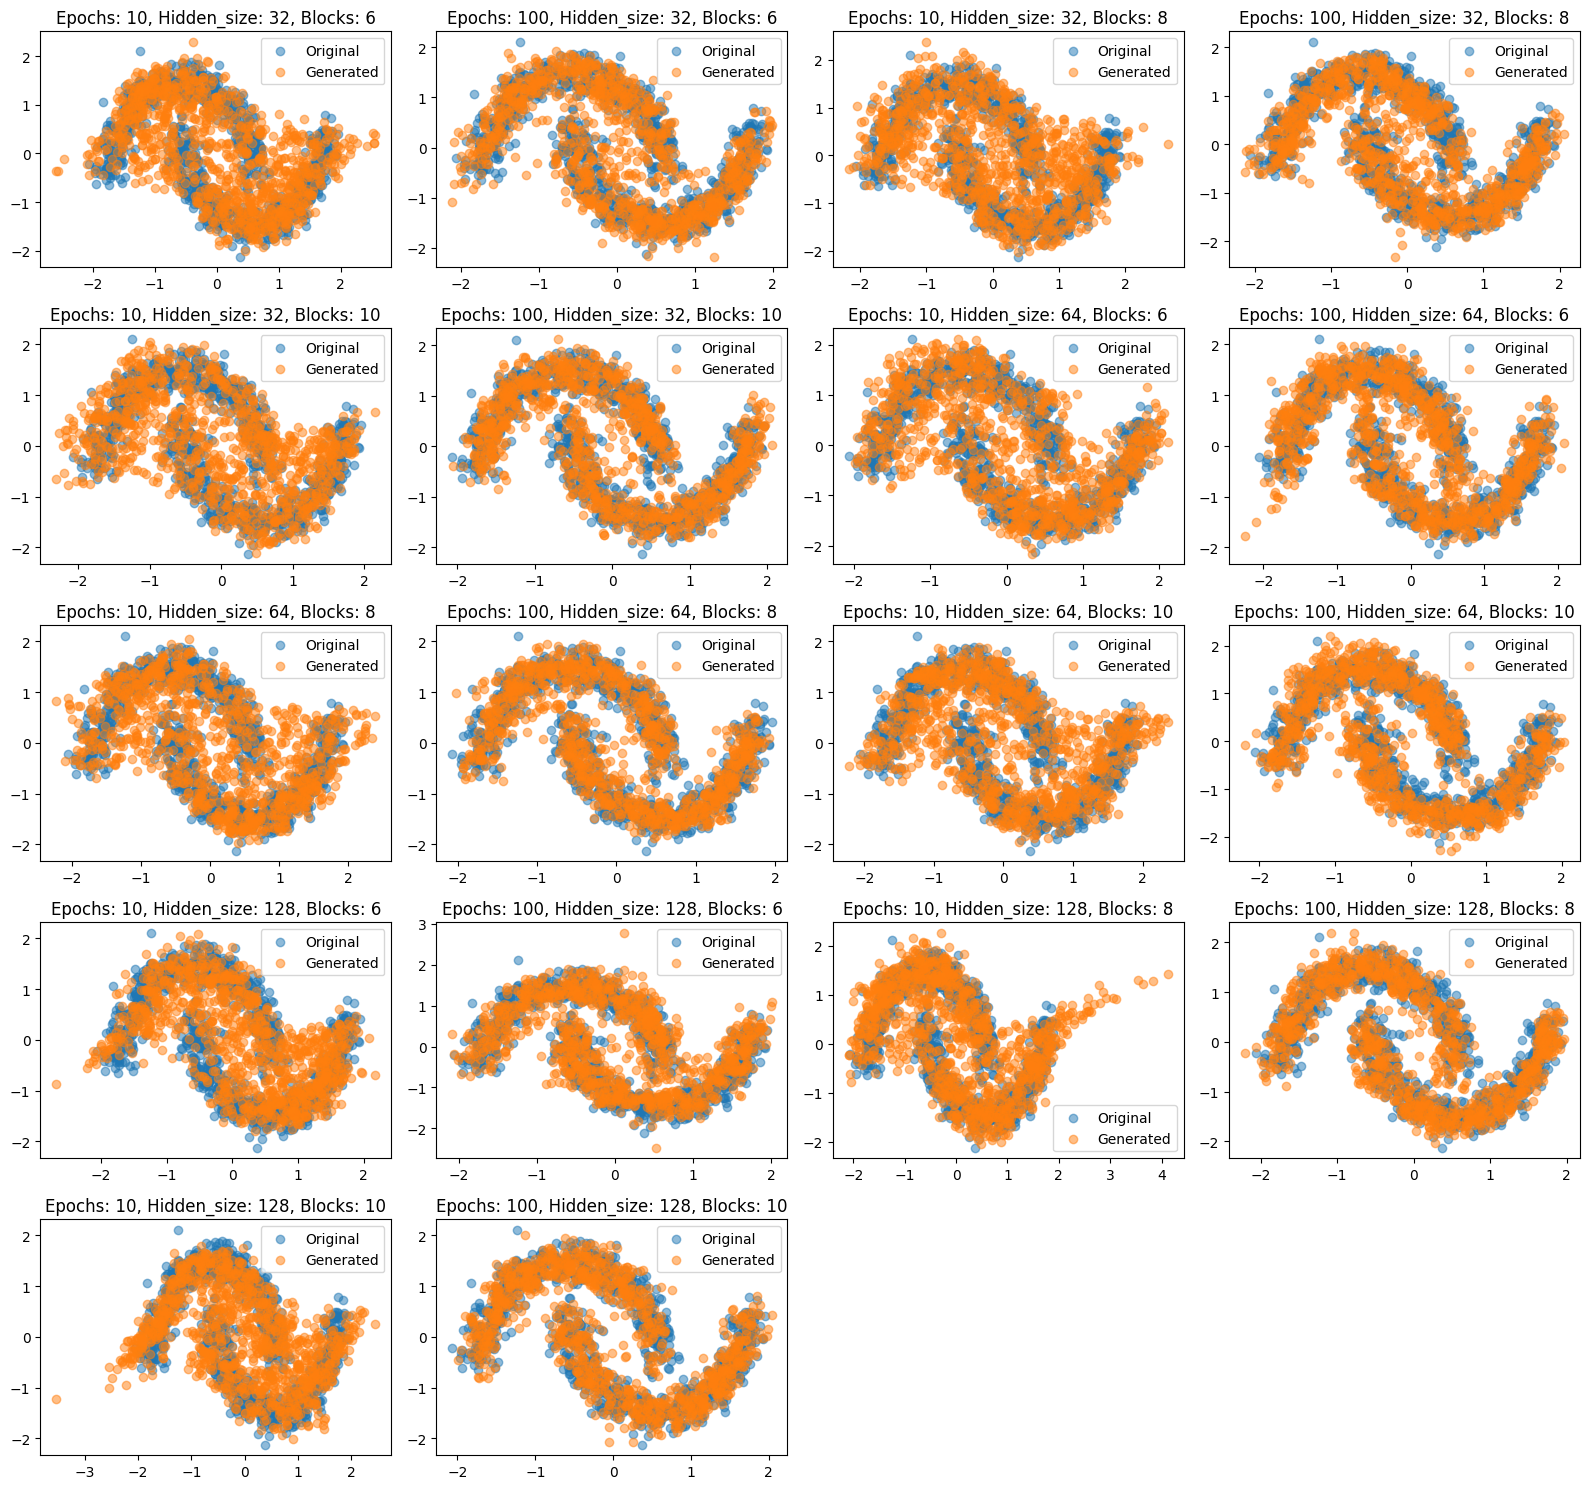

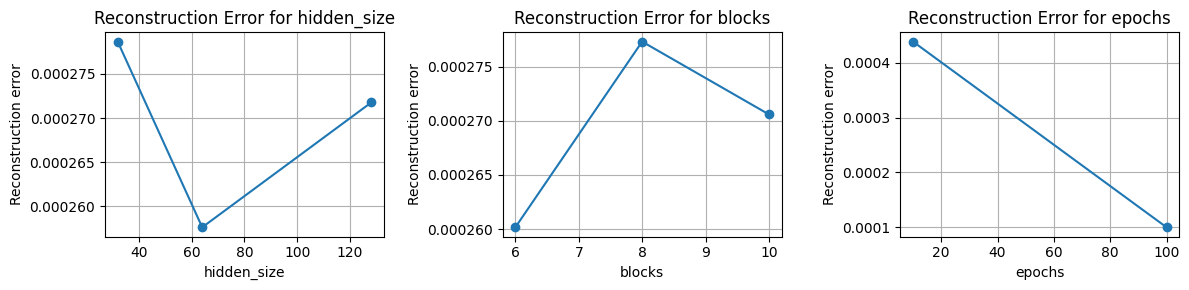

In [16]:
n_samples = 1000
noise = 0.1
input_size = 2
lr = 0.001
hidden_size_list = [32, 64, 128]
blocks_list = [6, 8, 10]
epochs_list = [10, 100]

results = evaluate_hyperparameters(n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list)

Optimal hidden_size is around 60 and for blocks is around 6 and for higher epochs we get low error.

MMD

<div style="color: green; font-weight:bold"><ul>
<li>We realized that the whole algorithm for MMD calculation is done better in sample solution.</li>
</ul></div>

In [17]:
def inverse_multi_quadratic_kernel(x, y, bandwidth=1.0):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.detach().numpy()

    pairwise_dists = cdist(x, y, metric='sqeuclidean')
    return bandwidth / (bandwidth + pairwise_dists)

def compute_mmd(test_set, generated_set, bandwidth=1.0):
    xx = inverse_multi_quadratic_kernel(test_set, test_set, bandwidth)
    yy = inverse_multi_quadratic_kernel(generated_set, generated_set, bandwidth)
    xy = inverse_multi_quadratic_kernel(test_set, generated_set, bandwidth)

    mmd = np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)
    return mmd

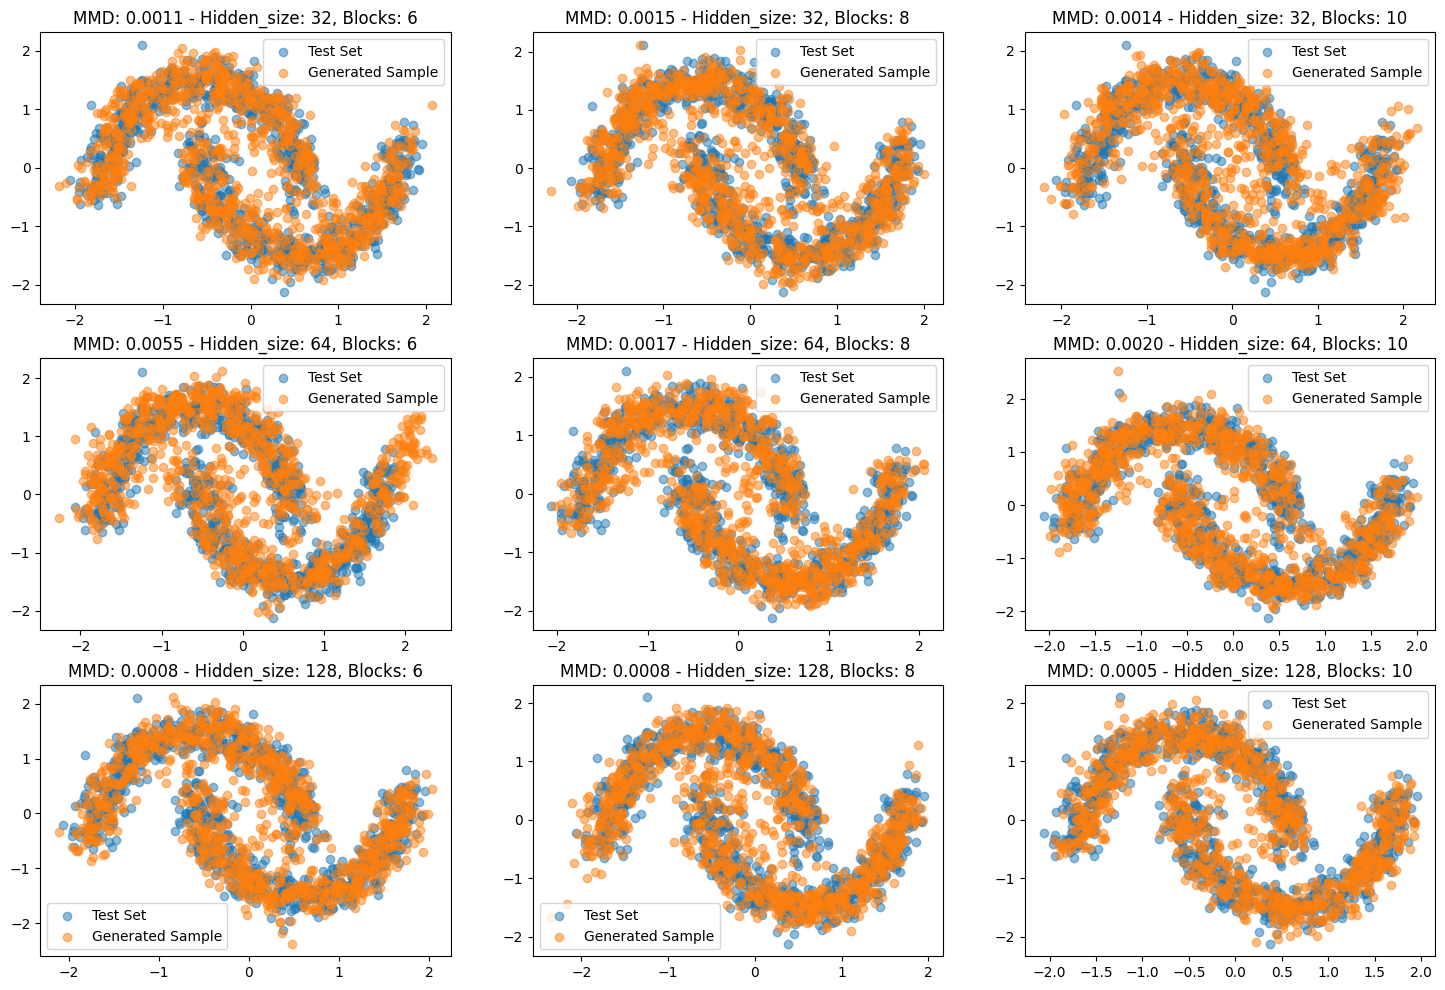

In [18]:
bandwidth = 1.0
n_samples = 1000
epochs = 100
hidden_size_list = [32, 64, 128]
blocks_list = [6, 8, 10]

test_dataset = generate_data(n_samples, noise, random_state=1)

fig, axes = plt.subplots(len(hidden_size_list), len(blocks_list), figsize=(18, 12))
for i, hidden_size in enumerate(hidden_size_list):
    for j, blocks in enumerate(blocks_list):
        ax = axes[i,j]
        model = RealNVP(input_size, hidden_size, blocks)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = TensorDataset(test_dataset, torch.zeros(test_dataset.size(0)))
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

        train_inn(model, data_loader, optimizer,  epochs)

        # Generate synthetic samples using RealNVP
        generated_samples = model.sample(n_samples).detach().numpy()

        # Compute MMD
        mmd_value = compute_mmd(test_dataset, generated_samples, bandwidth=bandwidth)

        ax.scatter(test_dataset[:, 0], test_dataset[:, 1], alpha=0.5, label='Test Set')
        ax.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated Sample')
        ax.set_title(f'MMD: {mmd_value:.4f} - Hidden_size: {hidden_size}, Blocks: {blocks}')
        ax.legend()
plt.legend()
plt.show()


Model performs well according to MMD

GMM

<div style="color: green; font-weight:bold"><ul>
<li>Our logic to form hexagonal gmm plot is more dynamic but also much more computationally expensive. It could have been done in a much simpler way as given in sample solution</li>
</ul></div>

In [19]:
def hexa_gmm(n_samples, radius=1, std_dev=0.1):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]
    centers = np.array([[radius * np.cos(angle), radius * np.sin(angle)] for angle in angles])

    data = np.vstack([np.random.multivariate_normal(center, np.eye(2) * std_dev**2, size=n_samples // 6) for center in centers])

    gmm = GaussianMixture(n_components=6, covariance_type='spherical', random_state=42)
    gmm.fit(data)

    samples, _ = gmm.sample(n_samples)
    return samples

<div style="color: green; font-weight:bold"><ul>
<li>Bug: We missed to pass learning rate, lr, as parameter of function.</li>
</ul></div>

In [20]:
def train_gmm_inn(model, n_samples, epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()

        x_data = hexa_gmm(n_samples)
        x_data = torch.tensor(x_data, dtype=torch.float32)

        z, log_det = model(x_data)
        loss = torch.mean(0.5 * torch.sum(z**2, -1) - log_det)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

<div style="color: green; font-weight:bold"><ul>
<li>We believe that our representation of results is better here.</li>
</ul></div>

Epoch [10/100], Loss: 0.0674
Epoch [20/100], Loss: -0.2967
Epoch [30/100], Loss: -0.5030
Epoch [40/100], Loss: -0.6167
Epoch [50/100], Loss: -0.7590
Epoch [60/100], Loss: -0.8589
Epoch [70/100], Loss: -0.9856
Epoch [80/100], Loss: -0.8239
Epoch [90/100], Loss: -1.0253
Epoch [100/100], Loss: -1.1146


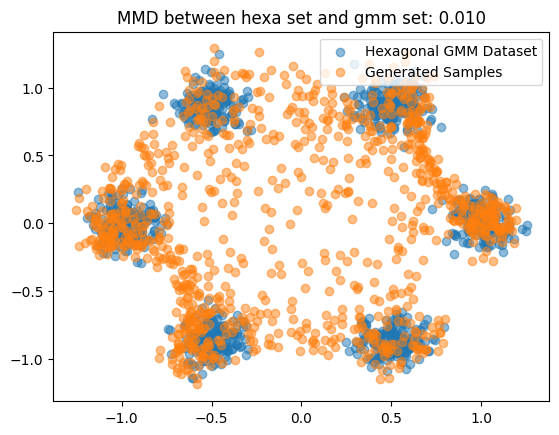

In [21]:
n_samples = 1000
hidden_size = 64
blocks = 10
epochs = 100
radius = 1.0
std_dev = 0.1

hexa_dataset = hexa_gmm(n_samples, radius, std_dev)

gmm_model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
train_gmm_inn(gmm_model, n_samples, epochs)
gmm_dataset = gmm_model.sample(n_samples).detach().numpy()

mmd_value = compute_mmd(hexa_dataset, gmm_dataset, bandwidth=1.0)

plt.scatter(hexa_dataset[:, 0], hexa_dataset[:, 1], alpha=0.5, label='Hexagonal GMM Dataset')
plt.scatter(gmm_dataset[:,0], gmm_dataset[:,1], alpha=0.5, label='Generated Samples')
plt.title(f'MMD between hexa set and gmm set: {mmd_value:.3f}')
plt.legend()
plt.show()

The INN learns the distribution easily and performs well.

## Task 2


<div style="color: green; font-weight:bold"><ul>
<li>No significant difference in programming strategy to highlight here.</li>
<li>However, we believe that we have executed this task in more detailed manner, esuring modularity and respective output.</li>
</ul></div>

In [22]:
class ConditionalCouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.split1 = input_size // 2
        self.split2 = input_size - self.split1

        self.subnet = nn.Sequential(
            nn.Linear(self.split1 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * self.split2),
        )

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)
        log_jacob_det = torch.sum(s, dim=-1)

        if not rev:
            s = torch.exp(s)
            x2 = s * x2 + t
            return torch.cat([x1, x2], dim=-1), log_jacob_det
        else:
            s = torch.exp(-s)
            x2 = s * (x2 - t)
            return torch.cat([x1, x2], dim=-1)

def orthogonal_matrix(size):
    matrix = torch.randn(size, size)
    q, _ = torch.qr(matrix)
    return q


class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size):
        super().__init__()
        self.input_size = input_size
        self.condition_size = condition_size
        self.coupling_blocks = nn.ModuleList(
            [ConditionalCouplingBlock(input_size, hidden_size, condition_size) for _ in range(n_blocks)]
        )
        self.orthogonal_matrices = [orthogonal_matrix(input_size) for _ in range(n_blocks - 1)]

    def forward(self, x, cond, rev=False):
        cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=self.condition_size).float()
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        log_jacob_det = torch.zeros(x.shape[0], device=x.device)
        for i in range(len(self.coupling_blocks) - 1):
            x, ljd = self.coupling_blocks[i](x, cond)
            log_jacob_det += ljd
            x = torch.matmul(x, self.orthogonal_matrices[i])
        x, ljd = self.coupling_blocks[-1](x, cond)
        log_jacob_det += ljd
        return x, log_jacob_det

    def inverse(self, x, cond):
        for i in range(len(self.coupling_blocks) - 1, 0, -1):
            x = self.coupling_blocks[i](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[i - 1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        if cond is None:
            cond = torch.arange(self.condition_size)
        samples = []
        for c in cond:
            z = torch.randn(num_samples, self.input_size)

            cond_reshaped = torch.tensor([c.item()] * num_samples).reshape(-1, 1)
            cond_reshaped = nn.functional.one_hot(cond_reshaped.to(torch.int64), num_classes=self.condition_size).float().squeeze(1)

            samples.append(self.inverse(z, cond=cond_reshaped))
        return torch.cat(samples, dim=0)

In [23]:
def train_cinn_moons(model, batchsize=1000, epochs=1000, lr=0.001):
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_data, y_data = make_moons(n_samples=batchsize, shuffle=True, noise=0.1, random_state=42)
        x_data, y_data = torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.long)

        z, ljd = model(x_data, y_data)
        loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - ljd)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: -0.2184
Epoch [20/100], Loss: -0.6232
Epoch [30/100], Loss: -0.8926
Epoch [40/100], Loss: -1.1157
Epoch [50/100], Loss: -1.2952
Epoch [60/100], Loss: -1.4185
Epoch [70/100], Loss: -1.4846
Epoch [80/100], Loss: -1.5135
Epoch [90/100], Loss: -1.5395
Epoch [100/100], Loss: -1.5534


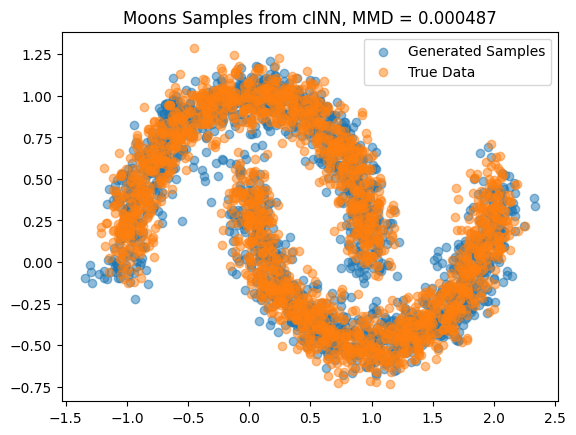

In [24]:
cINN_moons = ConditionalRealNVP(2, 64, 10, 2)
train_cinn_moons(cINN_moons, epochs=100)

# Visualizing
samples = cINN_moons.sample(1000)
true_moons_data, _ = make_moons(n_samples=2000, shuffle=True, noise=0.1, random_state=42)
true_moons_data = torch.tensor(true_moons_data)

plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), alpha=0.5, label="Generated Samples")
mmd_score = compute_mmd(samples, true_moons_data)
plt.scatter(true_moons_data[:, 0], true_moons_data[:, 1], alpha=0.5, label="True Data")
plt.legend()
plt.title(f"Moons Samples from cINN, MMD = {mmd_score:.6f}")
plt.show()

- Adding labels as a condition improves the flexibility of the model to learn conditional distributions.
- Using one-hot encoding of the labels ensures the model incorporates the class information effectively.


In [25]:
def make_gmm_samples(n_samples, radius=1.0, std_dev=0.1):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]
    centers = np.array([[radius * np.cos(angle), radius * np.sin(angle)] for angle in angles])
    data = np.vstack([
        np.random.multivariate_normal(center, np.eye(2) * (std_dev ** 2), size=n_samples // 6)
        for center in centers
    ])
    labels = np.concatenate([np.full(n_samples // 6, i) for i in range(6)])
    return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

def cluster_labels(cond):
    is_cluster_1 = torch.logical_or(cond == 4, cond == 5)
    return is_cluster_1.to(torch.int64)

In [26]:
def train_cinn_gmm(model, batchsize=1000, epochs=1000, lr=0.001, binary=False):
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_data, y_data = make_gmm_samples(batchsize)
        if binary:
            y_data = cluster_labels(y_data)
        z, ljd = model(x_data, y_data)
        loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - ljd)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % (epochs // 5) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Training Conditional INN for GMM
Epoch [20/100], Loss: -1.7785
Epoch [40/100], Loss: -2.6014
Epoch [60/100], Loss: -3.3475
Epoch [80/100], Loss: -3.5354
Epoch [100/100], Loss: -3.5941
Generating Samples


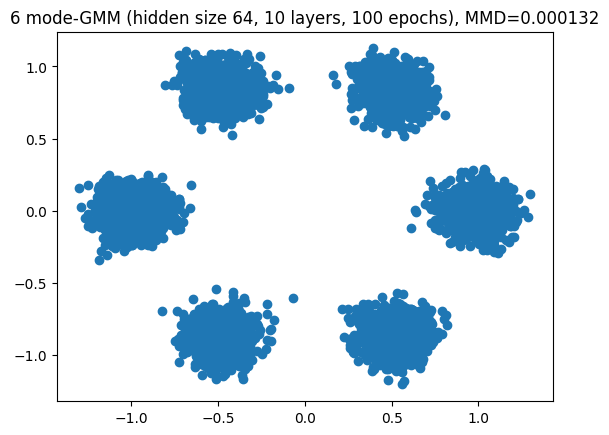

In [27]:
input_size = 2
hidden_size = 64
n_blocks = 10
condition_size = 6
epochs = 100

cINN_for_GMM = ConditionalRealNVP(input_size, hidden_size, n_blocks, condition_size)

print("Training Conditional INN for GMM")
train_cinn_gmm(cINN_for_GMM, epochs=epochs)

print("Generating Samples")
gmm_samples = cINN_for_GMM.sample(1000, cond=torch.arange(condition_size))
true_gmm_data, _ = make_gmm_samples(6000)

plt.scatter(gmm_samples[:, 0].detach().numpy(), gmm_samples[:, 1].detach().numpy(), label="Generated Samples")
mmd_score = compute_mmd(gmm_samples, true_gmm_data)
plt.title(f"6 mode-GMM (hidden size {hidden_size}, {n_blocks} layers, {epochs} epochs), MMD={mmd_score:.6f}")
plt.show()

For 6 mode GMM it is performing a lot better.

In [28]:
def train_conditional_inn(model, data_fn, num_samples, epochs, lr, condition_size):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        x_data, y_data = data_fn(num_samples)
        x_data = torch.tensor(x_data, dtype=torch.float32)
        y_data = torch.tensor(y_data, dtype=torch.long)

        optimizer.zero_grad()
        z, ljd = model(x_data, y_data)
        loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - ljd)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

In [29]:
def evaluate_conditional_inn(model, data_fn, num_samples, condition_size, dataset_name):
    model.eval()
    samples = []
    true_data, true_labels = data_fn(num_samples)

    for label in range(condition_size):
        generated_samples = model.sample(num_samples, cond=torch.tensor([label]))
        samples.append(generated_samples)

    samples = torch.cat(samples, dim=0)
    mmd_score = compute_mmd(samples, true_data)

    plt.scatter(true_data[:, 0], true_data[:, 1], alpha=0.5, label="True Data")
    plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), alpha=0.5, label="Generated Samples")
    plt.title(f"{dataset_name}, MMD = {mmd_score:.6f}")
    plt.legend()
    plt.show()

In [30]:
def generate_data_labels(n_samples=1000, noise=0.1, random_state=1):
    data, labels = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    data = StandardScaler().fit_transform(data)

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    return data, labels

Epoch [10/100], Loss: 0.2350
Epoch [20/100], Loss: -0.0113
Epoch [30/100], Loss: -0.2527
Epoch [40/100], Loss: -0.4408
Epoch [50/100], Loss: -0.5478
Epoch [60/100], Loss: -0.5959
Epoch [70/100], Loss: -0.6262
Epoch [80/100], Loss: -0.6411
Epoch [90/100], Loss: -0.6528
Epoch [100/100], Loss: -0.6586


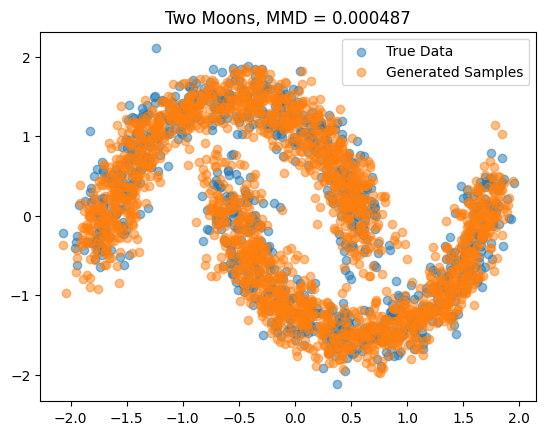

Epoch [10/100], Loss: -0.4337
Epoch [20/100], Loss: -1.5859
Epoch [30/100], Loss: -2.5631
Epoch [40/100], Loss: -3.2059
Epoch [50/100], Loss: -3.4711
Epoch [60/100], Loss: -3.5788
Epoch [70/100], Loss: -3.5183
Epoch [80/100], Loss: -3.5435
Epoch [90/100], Loss: -3.5805
Epoch [100/100], Loss: -3.5649


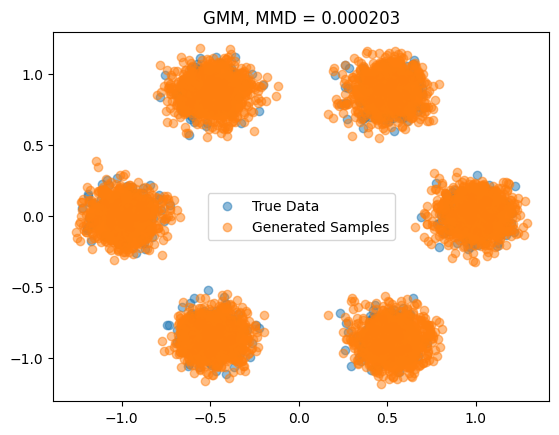

In [31]:
warnings.filterwarnings("ignore", category=UserWarning)

# Two Moons - Conditional INN
cINN_moons = ConditionalRealNVP(2, 64, 10, 2)
train_conditional_inn(cINN_moons, generate_data_labels, num_samples=1000, epochs=100, lr=0.001, condition_size=2)
evaluate_conditional_inn(cINN_moons, generate_data_labels, num_samples=1000, condition_size=2, dataset_name="Two Moons")

# GMM - Conditional INN
cINN_gmm = ConditionalRealNVP(2, 64, 10, 6)
train_conditional_inn(cINN_gmm, make_gmm_samples, num_samples=1000, epochs=100, lr=0.001, condition_size=6)
evaluate_conditional_inn(cINN_gmm, make_gmm_samples, num_samples=1000, condition_size=6, dataset_name="GMM")

In [32]:
def visualize_marginal_px(plain_inn, conditional_inn, num_samples, condition_size, data_fn):

    data = data_fn(num_samples * condition_size)
    if isinstance(data, tuple):
        true_data, _ = data
    else:
        true_data = data


    plain_samples = plain_inn.sample(num_samples * condition_size).detach().numpy()


    conditional_samples = []
    for label in range(condition_size):
        cond_samples = conditional_inn.sample(num_samples, cond=torch.tensor([label]))
        conditional_samples.append(cond_samples)
    conditional_samples = torch.cat(conditional_samples, dim=0).detach().numpy()


    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].scatter(true_data[:, 0], true_data[:, 1], alpha=0.5, label="True Data")
    axes[0].set_title("True Data")
    axes[0].legend()

    axes[1].scatter(plain_samples[:, 0], plain_samples[:, 1], alpha=0.5, label="Plain INN")
    axes[1].set_title("Plain INN Samples (Marginal $p(x)$)")
    axes[1].legend()

    axes[2].scatter(conditional_samples[:, 0], conditional_samples[:, 1], alpha=0.5, label="Conditional INN")
    axes[2].set_title("Conditional INN Samples (Marginal $p(x)$)")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    plain_mmd = compute_mmd(true_data, plain_samples)
    conditional_mmd = compute_mmd(true_data, conditional_samples)
    print(f"MMD (True vs Plain INN): {plain_mmd:.6f}")
    print(f"MMD (True vs Conditional INN): {conditional_mmd:.6f}")

In [33]:
model_plain = RealNVP(input_size=2, hidden_size=64, blocks=10)
train_data = generate_data(n_samples=1000, noise=0.1)
train_dataset = TensorDataset(train_data, torch.zeros(train_data.size(0)))
data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

optimizer = optim.Adam(model_plain.parameters(), lr=0.001)
train_inn(model_plain, data_loader, optimizer, epochs=100)


# GMM
model_plain_gmm = RealNVP(input_size=2, hidden_size=64, blocks=10)
train_data, _ = make_gmm_samples(n_samples=1000)
train_dataset = TensorDataset(train_data, torch.zeros(train_data.size(0)))
data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

optimizer = optim.Adam(model_plain_gmm.parameters(), lr=0.001)
train_inn(model_plain_gmm, data_loader, optimizer, epochs=100)


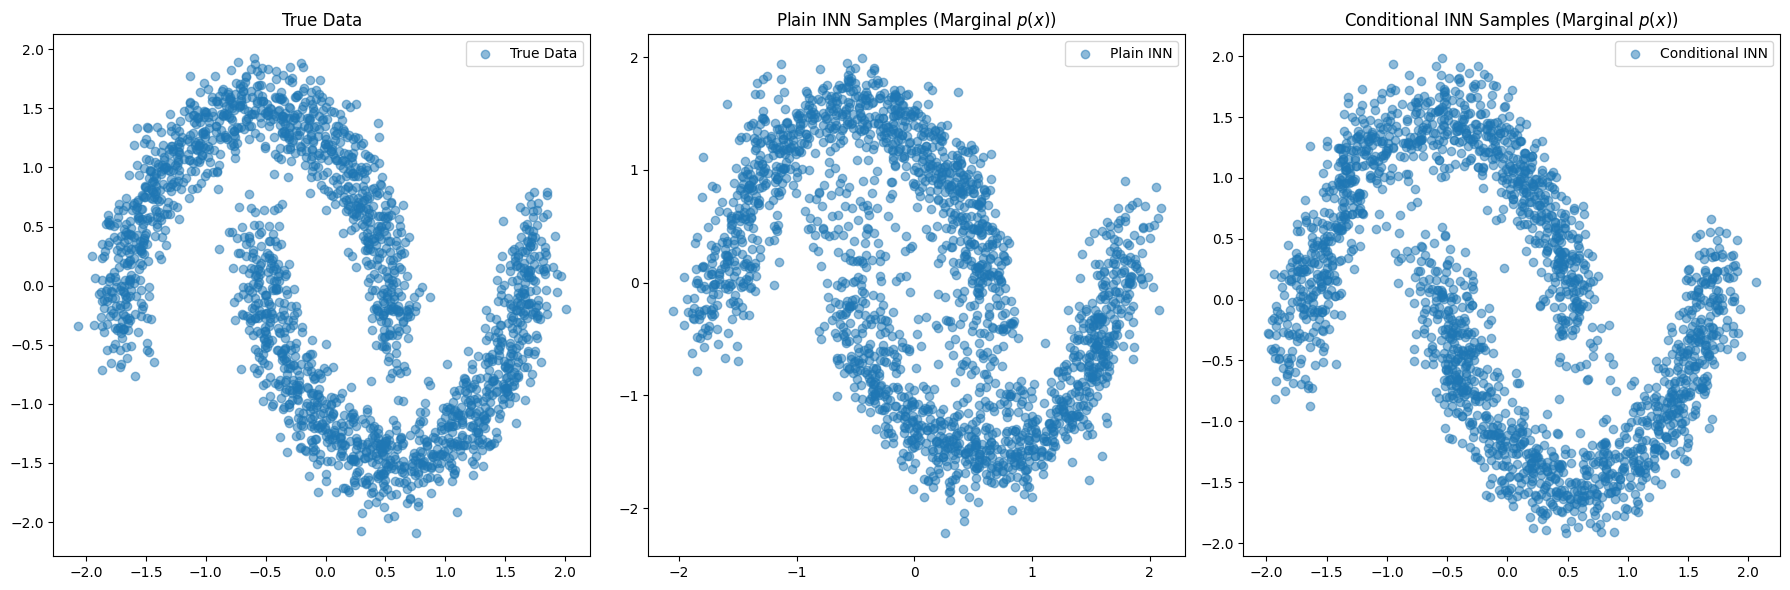

MMD (True vs Plain INN): 0.001371
MMD (True vs Conditional INN): 0.000512


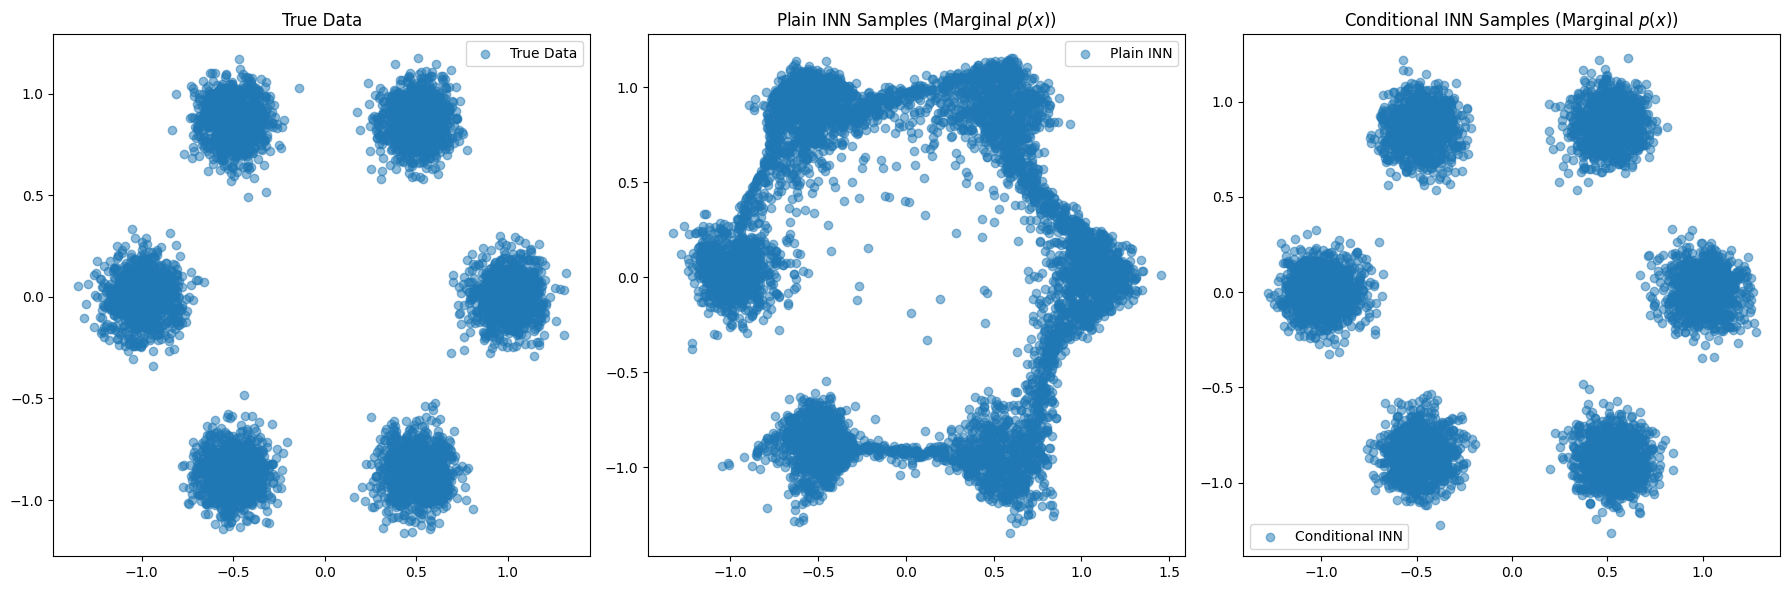

MMD (True vs Plain INN): 0.001263
MMD (True vs Conditional INN): 0.000120


In [34]:
visualize_marginal_px(plain_inn=model_plain,
                      conditional_inn=cINN_moons,
                      num_samples=1000,
                      condition_size=2,
                      data_fn=generate_data)

visualize_marginal_px(plain_inn=model_plain_gmm,
                      conditional_inn=cINN_gmm,
                      num_samples=1000,
                      condition_size=6,
                      data_fn=make_gmm_samples)

- The conditional INN performs well in generating points for specific labels, showing clear separation between classes.
- Comparing the marginal and conditional distributions highlights the benefit of using conditions for specific labels.
- Conditional training improves interpretability but introduces additional complexity in model design.

## Task 3

### Task 3.1

<div style="color: green; font-weight:bold"><ul>
<li>No significant difference in programming strategy to highlight here as the training method is following from task 1. However, the main difference is that we are using data loader as discussed in task 1</li>
<li>About the results of trained model, we tried presenting the generalized distribution using PCA and individually for a pair of dimensions, and also showed the gaussian distribution for dimension pair.</li>
<li>About the generated output, sample solution is using digit 5, while we tried presenting all digits with the MMD score.</li>
</ul></div>

In [35]:
def train_digit_inn(model, optimizer, train_data, epochs, batch_size):

    data_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_loader:
            optimizer.zero_grad()

            batch = batch[0]

            z, log_jacob_det = model(batch)

            loss = -torch.mean(-0.5 * torch.sum(z**2 + torch.log(torch.tensor(2 * torch.pi, device=z.device) + 1e-8), dim=1) + log_jacob_det)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.3f}")

    return losses

2-dim PCA to observe of 64 dimensional data in 2-D space


Epoch 1/500, Loss: 40.608
Epoch 21/500, Loss: -66.952
Epoch 41/500, Loss: -81.921
Epoch 61/500, Loss: -88.851
Epoch 81/500, Loss: -96.003
Epoch 101/500, Loss: -100.154
Epoch 121/500, Loss: -101.770
Epoch 141/500, Loss: -107.546
Epoch 161/500, Loss: -105.659
Epoch 181/500, Loss: -112.003
Epoch 201/500, Loss: -115.703
Epoch 221/500, Loss: -114.706
Epoch 241/500, Loss: -118.680
Epoch 261/500, Loss: -119.878
Epoch 281/500, Loss: -121.352
Epoch 301/500, Loss: -122.598
Epoch 321/500, Loss: -124.812
Epoch 341/500, Loss: -126.640
Epoch 361/500, Loss: -126.223
Epoch 381/500, Loss: -124.275
Epoch 401/500, Loss: -128.790
Epoch 421/500, Loss: -126.937
Epoch 441/500, Loss: -130.524
Epoch 461/500, Loss: -132.181
Epoch 481/500, Loss: -130.260


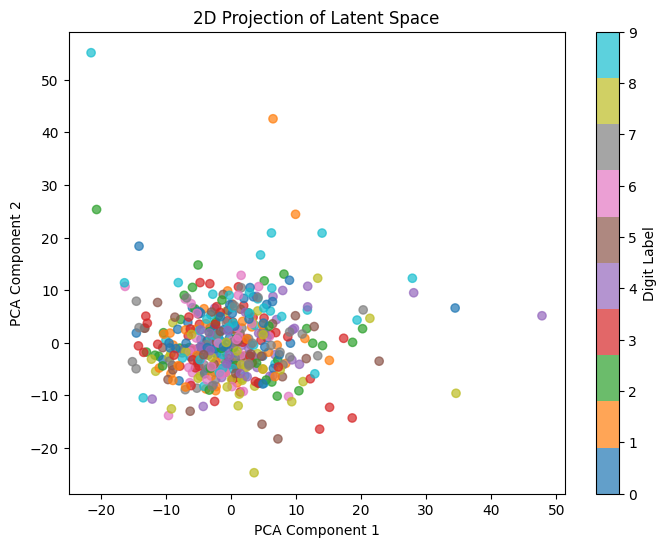

In [36]:
digits = load_digits()
x = digits.data / 16.0
y = digits.target

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=1)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)


input_size = x_train.size(1)
hidden_size = 128
blocks = 10
epochs = 500
batch_size = 128
lr = 0.001

model = RealNVP(input_size, hidden_size, blocks)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_digit_inn(model, optimizer, x_train, epochs, batch_size)

z, _ = model(x_test)
z = z.detach().numpy()

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(label="Digit Label")
plt.title("2D Projection of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

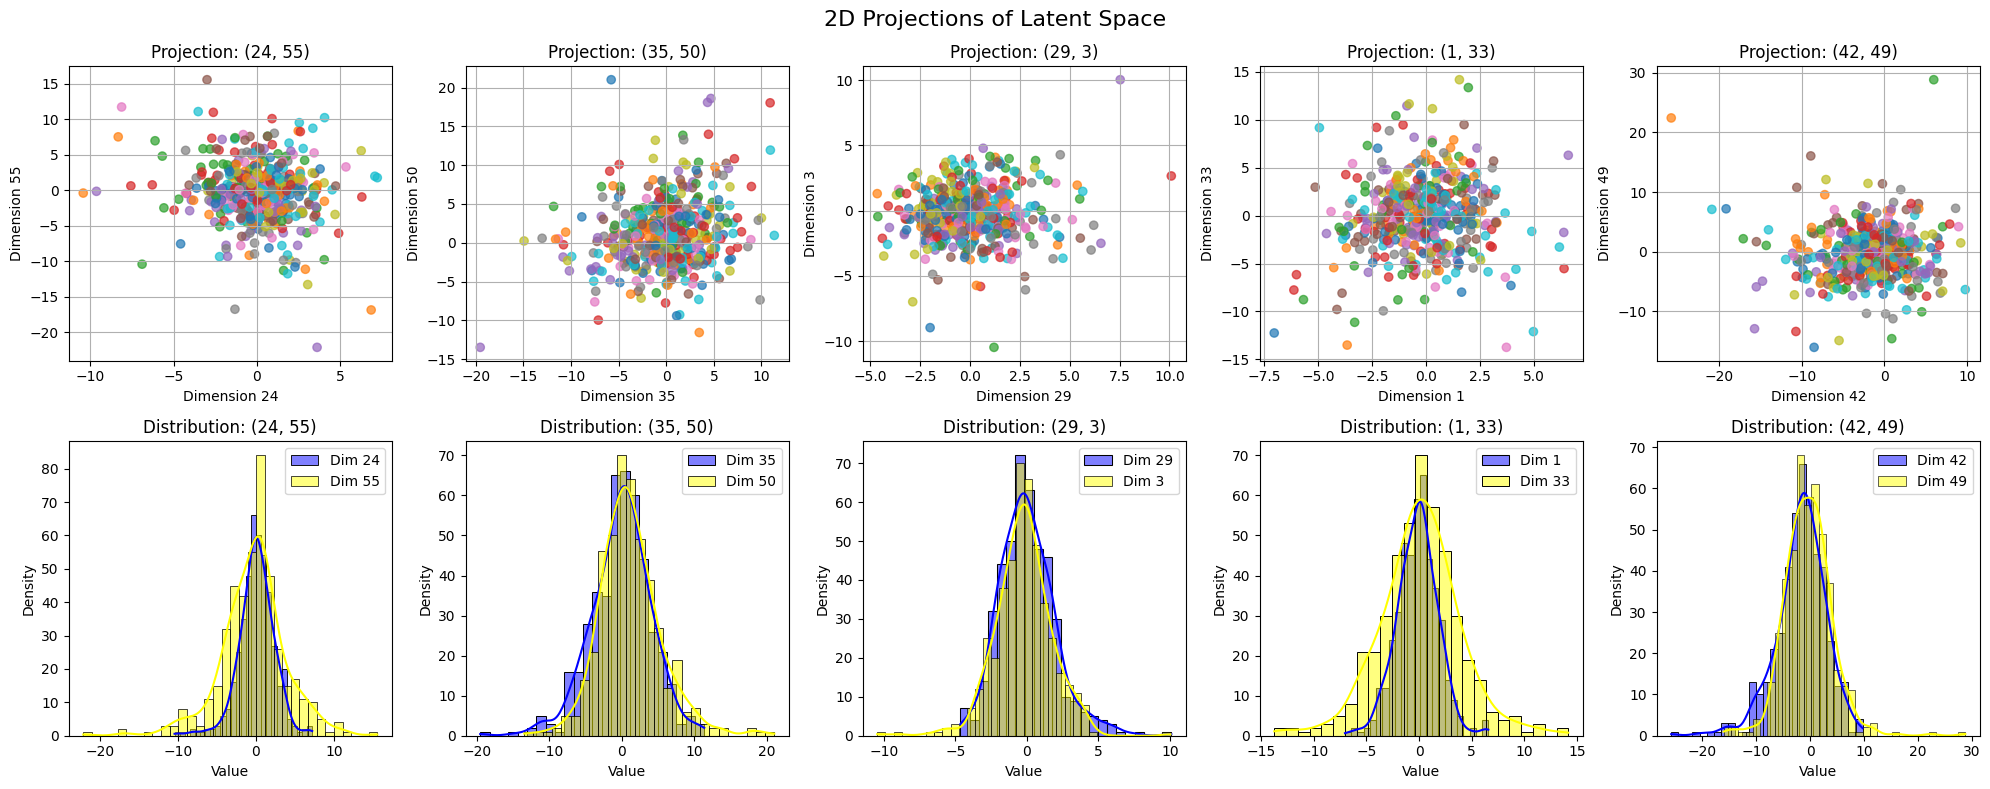

In [37]:
def projections_2d(latent_codes, dims, title="2D Projections of Latent Space"):
    num_plots = len(dims)
    fig, axes = plt.subplots(2, num_plots, figsize=(4*num_plots, 8))

    if num_plots == 1:
        axes = [[axes[0]], [axes[1]]]

    for i, (dim1, dim2) in enumerate(dims):
        ax = axes[0][i]
        ax.scatter(latent_codes[:, dim1], latent_codes[:, dim2], c=y_test, cmap='tab10', alpha=0.7)
        ax.set_xlabel(f"Dimension {dim1}")
        ax.set_ylabel(f"Dimension {dim2}")
        ax.set_title(f"Projection: ({dim1}, {dim2})")
        ax.grid(True)

        ax_hist = axes[1][i]
        sns.histplot(latent_codes[:, dim1], kde=True, ax=ax_hist, label=f"Dim {dim1}", color="blue", alpha=0.5)
        sns.histplot(latent_codes[:, dim2], kde=True, ax=ax_hist, label=f"Dim {dim2}", color="yellow", alpha=0.5)
        ax_hist.set_title(f"Distribution: ({dim1}, {dim2})")
        ax_hist.set_xlabel("Value")
        ax_hist.set_ylabel("Density")
        ax_hist.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


dims = [(24, 55), (35, 50), (29, 3), (1, 33), (42, 49)]
projections_2d(z, dims)

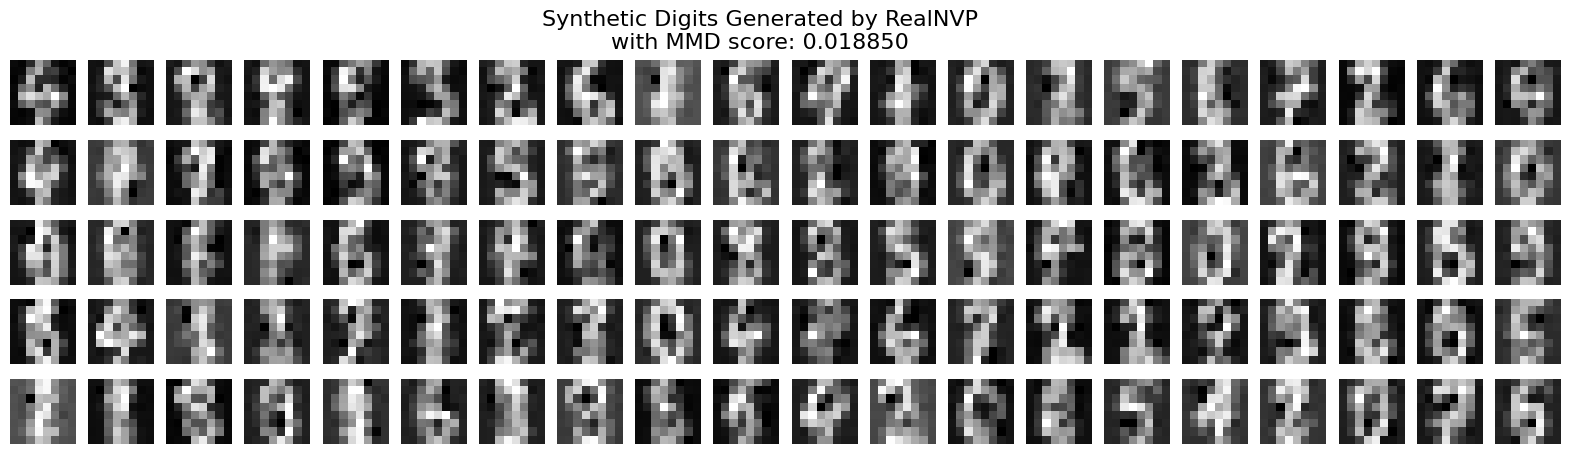

In [38]:
n_samples = 100
synthetic_digits = model.sample(n_samples).detach().numpy()

fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    if i < n_samples:
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Synthetic Digits Generated by RealNVP\nwith MMD score: {compute_mmd(x_test, synthetic_digits, bandwidth=bandwidth):4f}", fontsize=16)
plt.show()

- Training on 64-dimensional data is more challenging due to the curse of dimensionality.
- Introducing a bottleneck by focusing on the first k dimensions helps reduce the complexity and improves training stability.

### Task 3.2

<div style="color: green; font-weight:bold"><ul>
<li>No significant difference in programming strategy to highlight here as the model class and training method are following from task 1, by only introducing bottleneck.</li>
</ul></div>

In [87]:
class BottleneckRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, bottleneck):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.bottleneck = bottleneck

        self.coupling_blocks = nn.ModuleList([CouplingLayer(input_size, hidden_size) for _ in range(n_blocks)])
        self.orthogonal_matrices = [gram_schmidt(input_size) for _ in range(n_blocks - 1)]

    def forward(self, x, rev=False):
        if rev:
            return self._inverse(x)
        return self._forward(x)

    def _forward(self, x):
        ljd = torch.zeros((x.shape[0]))
        for l in range(self.n_blocks - 1):
            x, partial_ljd = self.coupling_blocks[l](x)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x):
        x_trunc = x[..., :self.bottleneck]
        x = torch.cat([x_trunc, torch.zeros((x.shape[0], self.input_size - self.bottleneck))], -1)
        for l in range(self.n_blocks - 1, 0, -1):
            x = self.coupling_blocks[l](x, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l - 1].T)
        x = self.coupling_blocks[0](x, rev=True)
        return x

    def sample(self, num_samples, fixed_non_bottleneck=True):
        if not fixed_non_bottleneck:
            z = torch.normal(mean=torch.zeros((num_samples, self.input_size)),
                             std=torch.ones((num_samples, self.input_size)))
        else:
            z0 = torch.normal(mean=torch.zeros((num_samples, self.bottleneck)),
                              std=torch.ones((num_samples, self.bottleneck)))
            z = torch.cat([z0, torch.zeros((num_samples, self.input_size - self.bottleneck))], -1)
        return self._inverse(z)

In [99]:
def train_bn(model, epochs=1000, lr=0.001, digit=None, l=1):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        digits_dataset = load_digits()
        data = digits_dataset["data"]
        if digit is not None:
            target = digits_dataset["target"]
            digit_idx = target == digit
            data = data[digit_idx]
        shuffle_idx = torch.randperm(data.shape[0])
        data = torch.Tensor(data[shuffle_idx])

        z, ljd = model(data)
        nll_loss = torch.sum(0.5 * torch.sum(z ** 2, -1) - ljd) / data.shape[0]

        x_rec = model(z, rev=True)
        diff = x_rec - data
        mse_loss = torch.sum(diff ** 2) / data.shape[0]

        loss = nll_loss + l * mse_loss

        loss.backward()
        optimizer.step()

        if (epoch + 1) % (epochs // 5) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/500], Loss: 152.2406
Epoch [200/500], Loss: 105.4386
Epoch [300/500], Loss: 85.1375
Epoch [400/500], Loss: 72.2962
Epoch [500/500], Loss: 62.3889
Epoch [100/500], Loss: 189.9373
Epoch [200/500], Loss: 125.0254
Epoch [300/500], Loss: 107.4688
Epoch [400/500], Loss: 97.0455
Epoch [500/500], Loss: 88.5922
Epoch [100/500], Loss: 170.7809
Epoch [200/500], Loss: 125.6750
Epoch [300/500], Loss: 105.5608
Epoch [400/500], Loss: 93.0878
Epoch [500/500], Loss: 84.9284
Epoch [100/500], Loss: 126.8537
Epoch [200/500], Loss: 96.4553
Epoch [300/500], Loss: 75.3949
Epoch [400/500], Loss: 59.0295
Epoch [500/500], Loss: 46.9630
Epoch [100/500], Loss: 123.6396
Epoch [200/500], Loss: 81.8567
Epoch [300/500], Loss: 62.7141
Epoch [400/500], Loss: 50.7097
Epoch [500/500], Loss: 40.3507


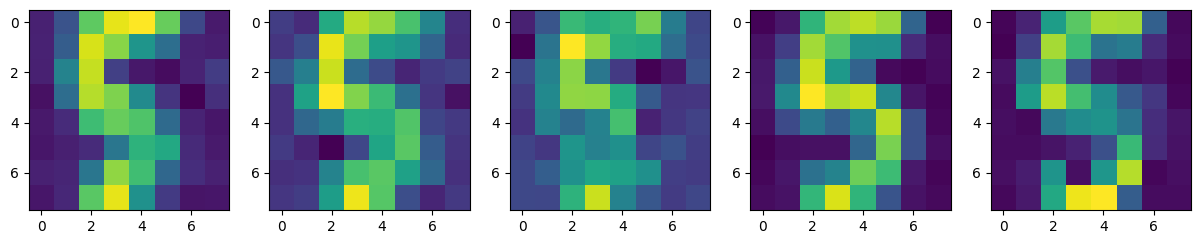

In [ ]:
figs, axs = plt.subplots(1, 5, figsize=(15, 3))
axs = axs.flatten()

for l in range(5):
    bn_fives_inn =BottleneckRealNVP(64, 128, 8, 8)
    train_bn(bn_fives_inn, epochs=500, digit=5, l=0.01)

    sample = bn_fives_inn.sample(1)
    axs[l].imshow(sample.reshape((8, 8)).detach().numpy())

- Sampling only from the first k dimensions results in more structured reconstructions, similar to an autoencoder.
- Sampling from remaining dimensions adds diversity but may degrade the quality if too much noise is introduced.

## Task 4

<div style="color: green; font-weight:bold"><ul>
<li>Mistake: We missed generating results from RandomForestClassifier.</li>
<li>We ensured normalizing the data which was missed by sample solution.</li>
<li>We ensured using data loader as this is a larger dataset.</li>
</ul></div>

In [103]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits

def train_digits_cinn(model, batch_size=100, epochs=100, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr)

    digits_dataset = load_digits()
    images = torch.Tensor(digits_dataset["data"])
    labels = torch.Tensor(digits_dataset["target"]).long()

    images = images / 16.0

    dataset = TensorDataset(images, labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (x_batch, y_batch) in enumerate(data_loader):
            optimizer.zero_grad()

            z, ljd = model(x_batch, y_batch)
            loss = torch.sum(0.5 * torch.sum(z**2, -1) - ljd) / batch_size
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(data_loader):.4f}")

- Using digit labels as a condition enables the model to generate class-specific synthetic data.
- A conditional approach simplifies training as the model learns separate distributions for each class.


Epoch [100/1000], Loss: -190.6618
Epoch [200/1000], Loss: -211.5321
Epoch [300/1000], Loss: -217.8456
Epoch [400/1000], Loss: -220.7098
Epoch [500/1000], Loss: -223.1945
Epoch [600/1000], Loss: -232.1038
Epoch [700/1000], Loss: -234.1210
Epoch [800/1000], Loss: -232.8707
Epoch [900/1000], Loss: -229.1789
Epoch [1000/1000], Loss: -237.6207


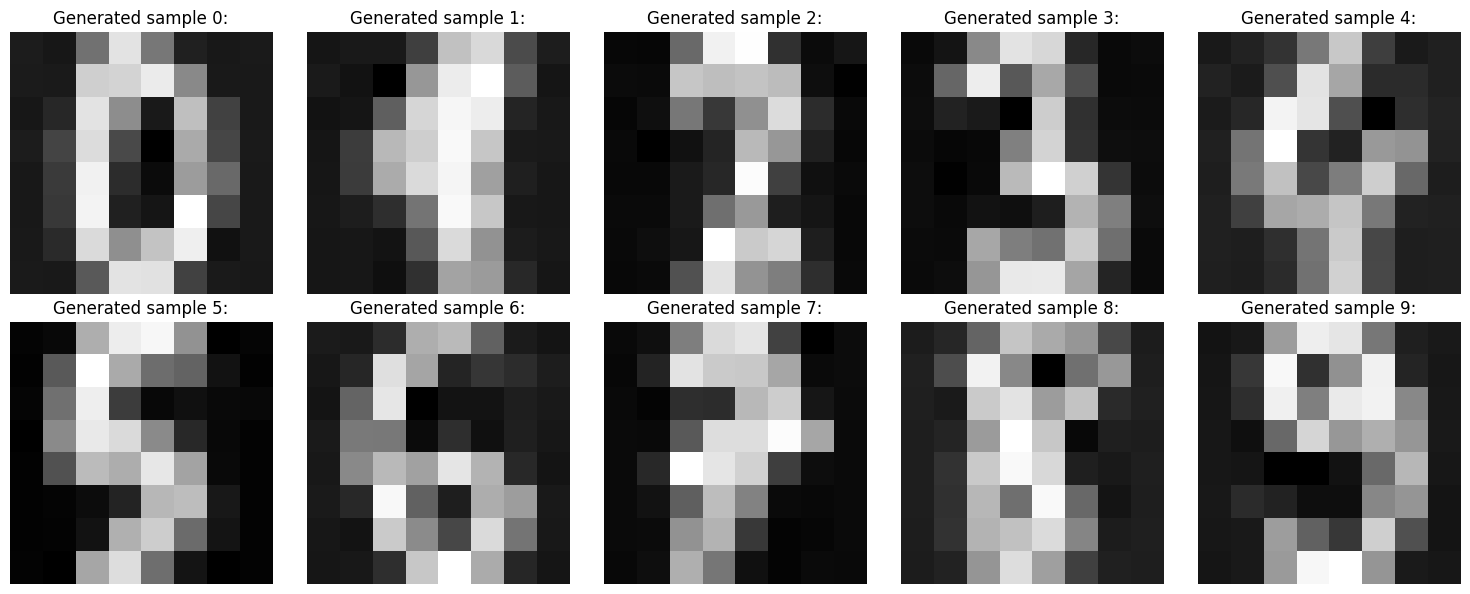

In [104]:
digits_cinn = ConditionalRealNVP(input_size=64, hidden_size=512, n_blocks=8, condition_size=10)
train_digits_cinn(digits_cinn, epochs=1000)

sample = digits_cinn.sample(1)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(sample[i].reshape((8, 8)).detach().cpu().numpy(), cmap="gray")
    axs[i].set_title(f"Generated sample {i}:")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

- The generated digits generally resemble the desired labels, showing the power of conditional INNs.
- Accuracy tests with classifiers confirm the quality of generated data.
- Conditional INNs perform better than standard INNs in structured data generation, especially for complex datasets like digits.